## Importing necessary libraries

- **pandas** - Used for data loading and storing in dataframes
- **sqlite3** - Library for leveraging SQL databases, used here due to its simlicity and efficiency in handling small amounts of data
- **geopy** - Used for distance between points calculation
- **matplotlib** - Leveraged for plotting purposes
- **mpl_toolkits.basemap** - Utilized for more complex map visualization (in this case showing Mercator map with points)
- **csv** - Used for applying specific value to quoting parameter to `pandas.read_csv()` to prevent from incorrect data reading due to multiple quotes in columns """
- **math** - Library which was used for Pythagorean theorem for calculating distance with usage of `math.square()`

In [118]:
import math
import csv
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.distance import geodesic

## Data Loading

Here we are using pandas `.read_csv()` method for reading data from csv file and storing it into pandas `DataFrame` which is clear and similar to SQL format. We are using also `csv` library to add a parameter to `.read_csv()` method to ignore quoting, since it could generate errors in correct reading the columns.

In [119]:
# Reading csv file and loading into DataFrame
data = pd.read_csv('points.csv', quoting=csv.QUOTE_NONE)

# Let's see the loaded data
data.head()

,name,latitude,longitude,height,date_added,metadata
0,Moscow,"""55.7558°""","""37.6173°""",0.200,"""2024-05-06""","""country=Russia;status=Capital"""
1,Ottawa,"""45° 25.29'""","""-75° 41.832' W""",0.070,"""2024-05-06""","""country=Canada;status=Capital"""
2,Beijing,"""39° 54' 15\""""","""116° 24' 26\"" E""",0.044,"""2024-05-06""","""country=China;status=Capital"""
3,Washington D.C.,"""38° 54' 25.92\"" N""","""-77° 2' 12.84\"" W""",0.025,"""2024-05-06""","""country=United States;status=Capital"""
4,Brasilia,"""-15.7942° S""","""-47.8822°""",1.172,"""2024-05-06""","""country=Brazil;status=Capital"""


## Useful functions
- Removing quotes
- Converting coordinates
- Visualizing points on map

In [121]:
# Quote removing function
def remove_quotes(value: str) -> str:
	"""
	Function which removes quotes at the beginning and at the end.

	Args:
			value (str): Value from the column which contains quotes.
			
	Returns:
			(str): Value with quotes removed.
	"""

	# Checking whether value is surrounded by quotes ("")
	if value[0] == '"' and value[-1] == '"':
		return value[1:-1]
	return value

In [122]:
# Converting coordinate function
def convert_coordinate(coord: str) -> float:
    """
    Function that converts various geographical coordinate formats to decimal degrees.
    
    Args:
        coord (str): Coordinate presented in different formats:
            1. Degrees with decimal (e.g., "34.1234°")
            2. Degrees and minutes with decimal (e.g., "34° 12.345'")
            3. Degrees, minutes, and seconds (e.g., "34° 12' 34"")
            4. Includes direction letters (N, E, S, W) (e.g., "34° 5' 15.22" W")
    
    Returns:
        converted_coord (float): Converted coordinate in decimal degrees format (1).
    """

    # Handling the case with NESW directions
    reverse = False
    if 'S' in coord or 'W' in coord:
        reverse = True

    for char in 'NESW':
        coord = coord.replace(char, "")
    
    # Replacing whitespaces for easier string manipulation
    coord = coord.replace(" ", "").replace("\\", "")
    
    # Initialize components
    degrees = 0
    minutes = 0
    seconds = 0
    
    print(coord)
    # Extracting degrees
    if '°' in coord:
        degrees = float(coord[: coord.index('°')])
        if degrees < 0:
            degrees *= -1
    # Extracting minutes
    if "'" in coord:
        minutes = float(coord[coord.index("°") + 1 : coord.index("'")])
    # Extracting seconds
    if '"' in coord:
        seconds = float(coord[coord.index("'") + 1 : coord.index('"')])
        
    # Calcualting result
    minutes += seconds / 60
    converted_coord = degrees + minutes / 60
    
    # Handling the case with NESW directions
    if reverse:
        converted_coord *= -1

    # Rounding to clean numbers with long decimal expansion (e.g. 23.666666666)
    converted_coord = round(converted_coord, 4)

    # Returning result
    return converted_coord

In [ ]:
# Perimeter calculation function
def calculate_perimeter(points: list[tuple[float, float, float]]) -> float:
    """
    Function responsible for calculating perimeter of the figure which contains all provided points.

    Args:
        data (list[tuple[float, float, float]]): List of tuples in which each tuple contains latitude, longitude and height of a point.
    Returns:
        perimeter (float): Calculated perimeter in kilometers.
    """
    
    perimeter = 0.0

    # Iterating through all points to calculate the perimeter of a figure containing all points considering the height
    for i in range(len(points)):
        current_point = points[i]

        if i == len(points) - 1:
            next_point = points[0]
        else:
            next_point = points[i + 1]

        # Calculating the horizontal (geodesic) distance between the two points (in kilometers)
        horizontal_distance = geodesic((current_point[0], current_point[1]), (next_point[0], next_point[1])).km

        # Calculate the vertical distance (difference in height between two points)
        height_difference = abs(next_point[2] - current_point[2])

        # Calculating the straight line distance considering height
        segment_length = math.sqrt(horizontal_distance ** 2 + height_difference ** 2)

        # Add the segment length to the perimeter
        perimeter += segment_length

    # Returning result
    return perimeter

## Data Cleaning and Normalization

- Removing unnecessary quotes in columns.
- Converting latitude and longitude to the same single format (degrees with decimal points).

In [123]:
# Removing quotes
for column in ['latitude', 'longitude', 'date_added', 'metadata']:
	data[column] = data[column].apply(remove_quotes)

# Checking if operations were successful
data.head()

,name,latitude,longitude,height,date_added,metadata
0,Moscow,55.7558°,37.6173°,0.200,2024-05-06,country=Russia;status=Capital
1,Ottawa,45° 25.29',-75° 41.832' W,0.070,2024-05-06,country=Canada;status=Capital
2,Beijing,"39° 54' 15\""","116° 24' 26\"" E",0.044,2024-05-06,country=China;status=Capital
3,Washington D.C.,"38° 54' 25.92\"" N","-77° 2' 12.84\"" W",0.025,2024-05-06,country=United States;status=Capital
4,Brasilia,-15.7942° S,-47.8822°,1.172,2024-05-06,country=Brazil;status=Capital


In [124]:
# Converting latitude as well as longitude into the same format (degree with decimal points) and creating new columns for the converted values
data['converted_latitude'] = data['latitude'].apply(convert_coordinate)
data['converted_longitude'] = data['longitude'].apply(convert_coordinate)

# # Printing the first 3 rows after above operations
data.head()[['latitude', 'longitude', 'converted_latitude', 'converted_longitude']]

55.7558°
45°25.29'
39°54'15"
38°54'25.92"
-15.7942°
-35.2809°
28°36.834'
51°30'26.04"
52.5200°
35°41'22.56"
48°51'24"
19°25.57'
30°2.66'
-34°36'36"
24°38.4'
37.6173°
-75°41.832'
116°24'26"
-77°2'12.84"
-47.8822°
149.1300°
77°12.54'
0°7'39.12"
13.4050°
139°41'30.12"
2.3522°
-99°7.59'
31°14.13'
-58°22'55.68"
46°43.2'


,latitude,longitude,converted_latitude,converted_longitude
0,55.7558°,37.6173°,55.7558,37.6173
1,45° 25.29',-75° 41.832' W,45.4215,-75.6972
2,"39° 54' 15\""","116° 24' 26\"" E",39.9042,116.4072
3,"38° 54' 25.92\"" N","-77° 2' 12.84\"" W",38.9072,-77.0369
4,-15.7942° S,-47.8822°,-15.7942,47.8822


## Setting up Database

In [120]:
# Establishing the connection to the database
conn = sqlite3.connect('points.db')

# Setting the control structure using .cursor() to enable executing queries in the future
cursor = conn.cursor()

# Query for dropping table if exist
drop_query = '''
DROP TABLE IF EXISTS points
'''

# Executing drop table query
cursor.execute(drop_query)

# Query for creating table points if not exists already with columns same as in csv file
create_query = '''
CREATE TABLE points (
    id INT PRIMARY KEY,
    name TEXT,
    latitude REAL,
    longitude REAL,
    height REAL,
    date_added TEXT,
    metadata TEXT
)
'''

# Executing create table query
cursor.execute(create_query)

# Commiting changes
conn.commit()

## Inserting Data

Iterating through data (`pandas.DataFrame`) using for loop and leveraging the `.iterrows()` method that returns the generator through which we can iterate. `row` variable is a `pandas.Series` object, so we are able to easily manipulate it.

In [125]:
# For each row insert it into database
for index, row in data.iterrows():
    # Creating insert query with parameterized inputs
    # This approach avoids syntax errors and protects against SQL injection attacks
    add_row_query = f'''
    INSERT INTO points (id, name, latitude, longitude, height, date_added, metadata) 
    VALUES (?, ?, ?, ?, ?, ?, ?)
    '''
    
    # Data to insert
    data_to_insert = (index, row['name'], row['converted_latitude'], row['converted_longitude'], row['height'], row['date_added'], row['metadata'])
    
    # Executing insert operation
    conn.execute(add_row_query, data_to_insert)
    
    # Commiting changes
    conn.commit()

## See Loaded Data

Check if data loaded successfully to the database and use `.fetchall()` coords to see that.

In [135]:
# Execute query that selects all rows from points table
cursor.execute('SELECT * FROM points LIMIT 5')

# Get all rows
rows = cursor.fetchall()

# Show selected rows
rows

[(0,
  'Moscow',
  55.7558,
  37.6173,
  0.2,
  '2024-05-06',
  'country=Russia;status=Capital'),
 (1,
  'Ottawa',
  45.4215,
  -75.6972,
  0.07,
  '2024-05-06',
  'country=Canada;status=Capital'),
 (2,
  'Beijing',
  39.9042,
  116.4072,
  0.044,
  '2024-05-06',
  'country=China;status=Capital'),
 (3,
  'Washington D.C.',
  38.9072,
  -77.0369,
  0.025,
  '2024-05-06',
  'country=United States;status=Capital'),
 (4,
  'Brasilia',
  -15.7942,
  47.8822,
  1.172,
  '2024-05-06',
  'country=Brazil;status=Capital')]

## Retrieving Necessary Data

In [137]:
# Executing a query for selecting necessary values for future visualization
points = cursor.execute('SELECT latitude, longitude, height FROM points').fetchall()

# Show fetched values
points

[(55.7558, 37.6173, 0.2),
 (45.4215, -75.6972, 0.07),
 (39.9042, 116.4072, 0.044),
 (38.9072, -77.0369, 0.025),
 (-15.7942, 47.8822, 1.172),
 (35.2809, 149.13, 0.582),
 (28.6139, 77.209, 0.216),
 (51.5072, -0.1275, 0.015),
 (52.52, 13.405, 0.034),
 (35.6896, 139.6917, 0.04),
 (48.8567, 2.3522, 0.035),
 (19.4262, -99.1265, 2.24),
 (30.0443, 31.2355, 0.023),
 (-34.61, -58.3821, 0.025),
 (24.64, 46.72, 0.612)]

## Map Visualization

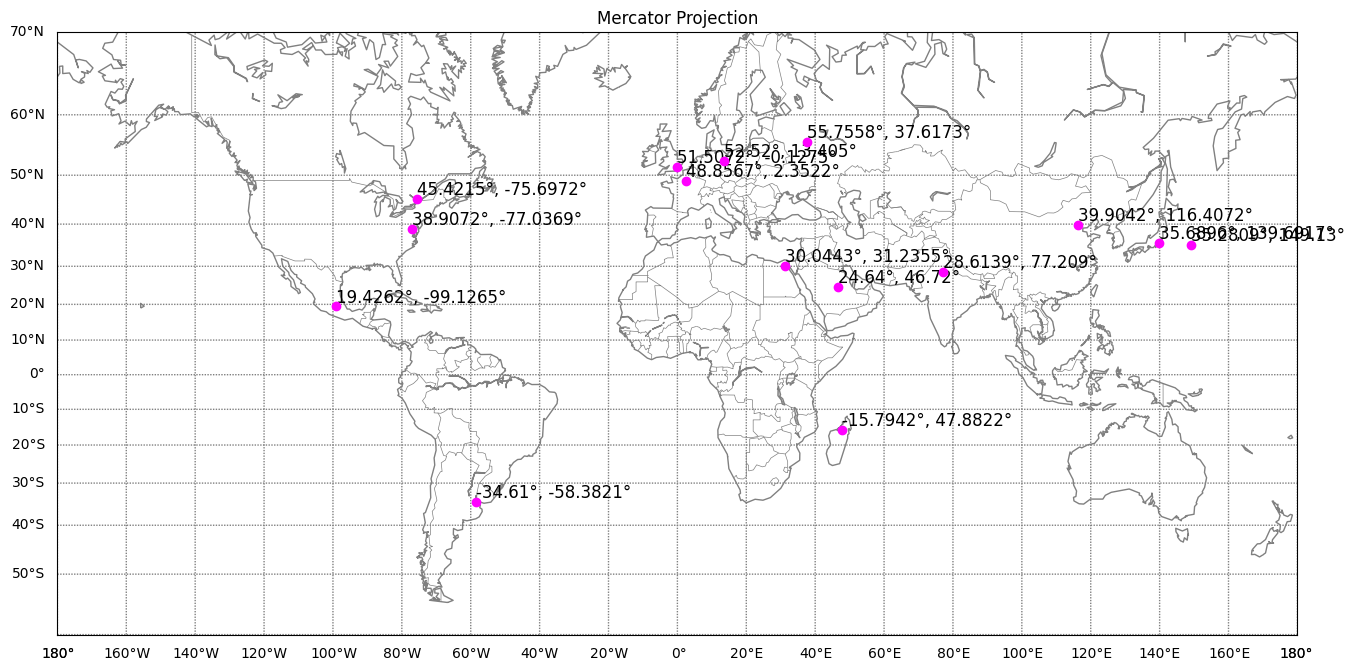

In [129]:
def visualize_points(points: list[tuple[float, float, float]]) -> None:
    """
    Function that plots geographical points on a Mercator map using Basemap.

    Args:
        points (list of tuples): List of (longitude, latitude) tuples.
    """

    # Creating a figure and axis
    plt.figure(figsize=(16, 10))
    
    # Creating a Mercator map specifying projection='merc' using Basemap
    m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')
    
    # Drawing coastlines and country boundaries
    m.drawcoastlines(color='gray')
    m.drawcountries(color='gray')
    
    # Drawing latitude and longitude lines
    m.drawparallels(range(-90, 91, 10), labels=[1, 0, 0, 0], color='gray')
    m.drawmeridians(range(-180, 181, 20), labels=[0, 0, 0, 1], color='gray')
    
    # Loop through each point and plot
    for longitude, latitude, _ in points:
        # Converting longitude and latitude to x and y coordinates for the map
        x, y = m(latitude, longitude)
        
        # Plotting point using matplotlib's scatter plot in magenta color
        m.scatter(x, y, marker='o', color='magenta', zorder=5)
        
        # Labeling the point with its coordinates and height
        label = f"{longitude}°, {latitude}°"
        plt.text(x, y, label, color='black', fontsize=12, ha='left', va='bottom')
    
    # Showing the plot
    plt.title('Mercator Projection')
    plt.show()

visualize_points(points)